# Multi-modal search with CLIP

Multi-modal models can calculate the embeddings of both text and image data, mapping the data points from both to the same semantic vector space. 

Some use cases enabled by multi-modal models:

- **Image classification**: Takes an image as input and predicts one or more classes (labels).
- **Image search**: Search for relevant or similar images.
- **Recommendations**: Generate product or ad recommendations based on images.

<img src="./img/multi-modal.png" alt="Multi-modal embeddings" width="600"/>

In this notebook we will demonstrate the use of a multi-modal semantic search algorithm. We will use the [clip-ViT-B-32](https://huggingface.co/sentence-transformers/clip-ViT-B-32) model that is a pre-trained version of [OpenAI CLIP Model](https://github.com/openai/CLIP). The accompanying python library of [sentence-transformers](https://github.com/UKPLab/sentence-transformers) makes it easy to interact with the model.

As a source for fotos, we use the [Unsplash Dataset Lite](https://unsplash.com/data), which contains about 25k images. See the [License](https://unsplash.com/license) about the Unsplash images. Download the dataset from their [github repository](https://github.com/unsplash/datasets).

Note: 25k images is rather small. If you search for really specific terms, the chance are high that no such photo exist in the collection.

## Download the pre-trained model and the dataset

In [1]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import torch
import pickle
import zipfile
from IPython.display import display
from IPython.display import Image as IPImage
import os
from tqdm.autonotebook import tqdm
torch.set_num_threads(4)

Load or download the CLIP transformer model:

In [2]:
model = SentenceTransformer('clip-ViT-B-32')

Download and extract the unsplash-25k dataset with 25000 images:

In [3]:
img_folder = 'photos/'
if not os.path.exists(img_folder) or len(os.listdir(img_folder)) == 0:
    os.makedirs(img_folder, exist_ok=True)

    photo_filename = './dataset/unsplash-25k-photos.zip'
    if not os.path.exists(photo_filename):
        util.http_get('http://sbert.net/datasets/' + photo_filename, photo_filename)

    with zipfile.ZipFile(photo_filename, 'r') as zf:
        for member in tqdm(zf.infolist(), desc='Extracting'):
            zf.extract(member, img_folder)

## Calculate image embeddings

Calculation of the embeddings for 25k image can be a time-consuming tasks, especially if you do not have access to a GPU. To speed things up, we will use pre-computed embeddings for the dataset. In a real-world scenario, you would calculate the embeddings for your custom image dataset. To calculate the embeddings locally, set `use_precomputed_embeddings` flag to `False`.

In [4]:
use_precomputed_embeddings = True

if use_precomputed_embeddings:
    emb_filename = './dataset/unsplash-25k-photos-embeddings.pkl'
    if not os.path.exists(emb_filename):
        util.http_get('http://sbert.net/datasets/' + emb_filename, emb_filename)

    with open(emb_filename, 'rb') as fIn:
        img_names, img_emb = pickle.load(fIn)
else:
    img_names = list(glob.glob(os.path.join(img_folder, '*.jpg')))
    img_emb = model.encode(
        [Image.open(filepath) for filepath in img_names],
        batch_size=128,
        convert_to_tensor=True,
        show_progress_bar=True
    )

print("Embeddings shape:", img_emb.shape)


Embeddings shape: (24996, 512)


## k-nearest neighbors algorithm

Semantic search in this context is conducted using a k-nearest neighbors (k-NN) algorithm applied to image embeddings, following the same approach outlined in the Retrieval Augmented Generation (RAG) notebook. In a practical, industrial setting, you would typically upload the image embeddings `img_emb` into a vector database. This database then efficiently carries out the optimized k-NN search. However, the `sentence_transformer` library offers a brute-force k-NN implementation for demonstrative purposes. Considering our dataset is relatively small, we'll opt for simplicity and use the built-in k-NN algorithm provided by the library.

The following function first calculates the embedding of the query, which can be either an image or a text string. The `util.semantic_search` function performs the *k-nn search* in the image embeddings, using the cosine similarity as distance metric. Finally, the top *k* ranked images are visualized.

In [5]:
def search(query, k=3):
    query_emb = model.encode([query], convert_to_tensor=True, show_progress_bar=False)
    hits = util.semantic_search(query_emb, img_emb, top_k=k)[0]

    print("Query:")
    display(query)
    for hit in hits:
        print(img_names[hit['corpus_id']])
        display(IPImage(os.path.join(img_folder, img_names[hit['corpus_id']]), width=300))

## Text-to-image search demo

Query:


'Two dogs playing in the snow'

FAcSe7SjDUU.jpg


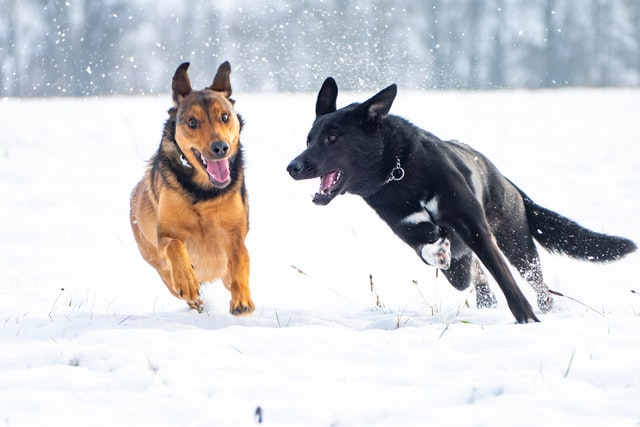

lyStEjlKNSw.jpg


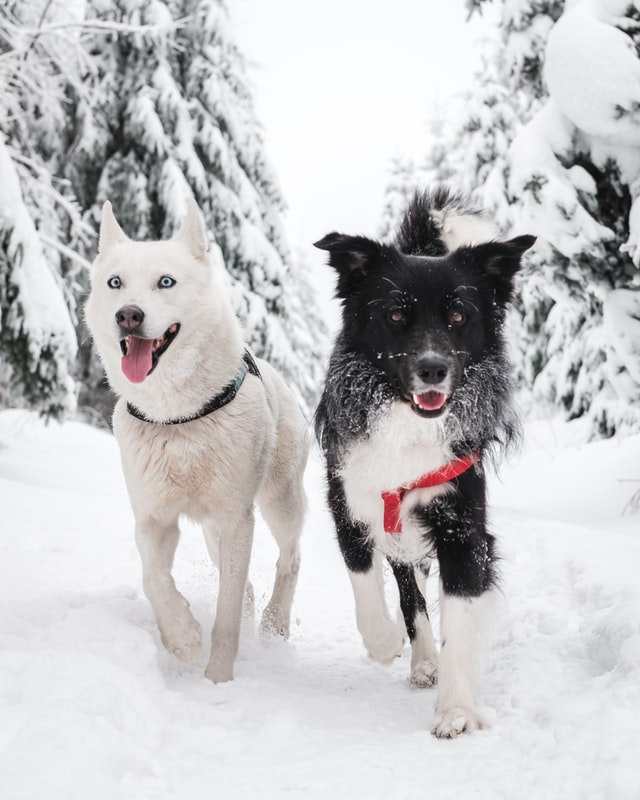

Hb6nGDgWztE.jpg


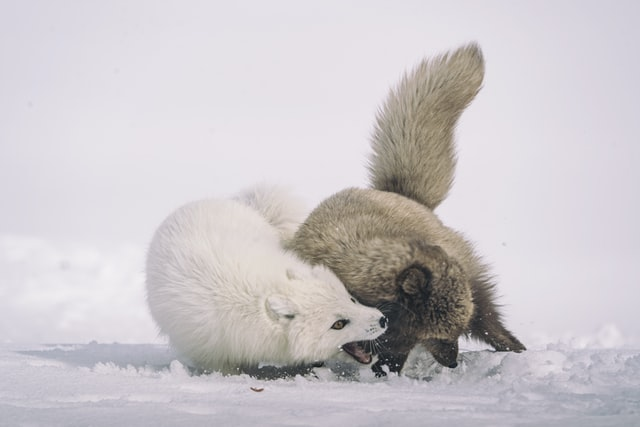

In [6]:
search("Two dogs playing in the snow")

Query:


'A sunset on the beach'

nfQ2QGhdQNc.jpg


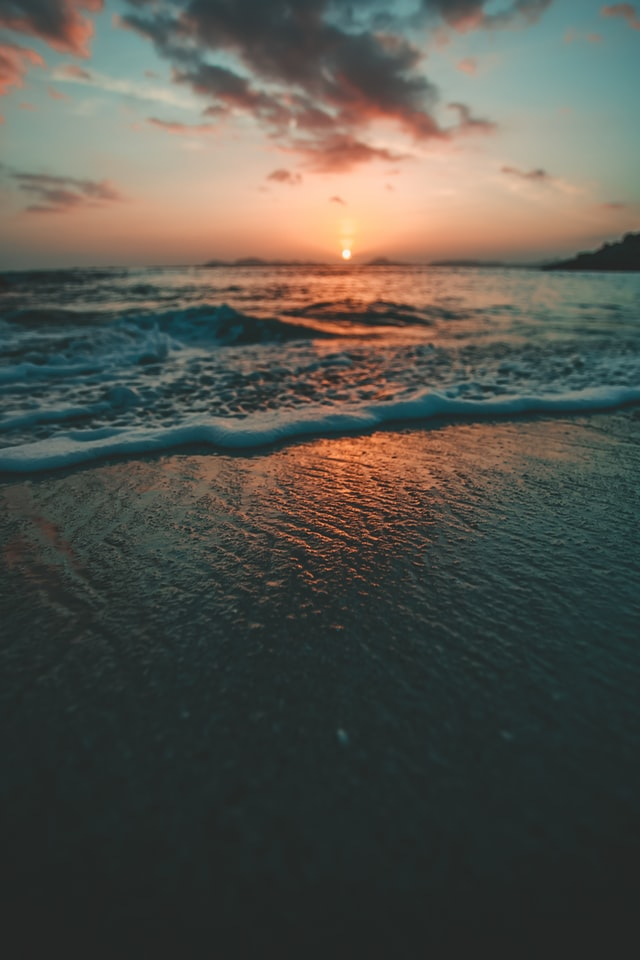

JC5U3Eyiyr4.jpg


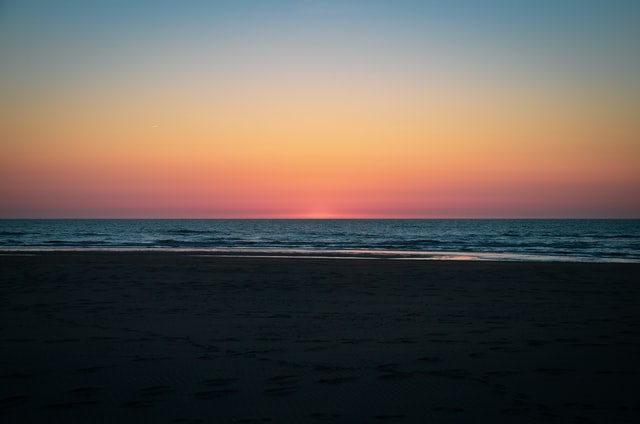

vlukOqxOA8o.jpg


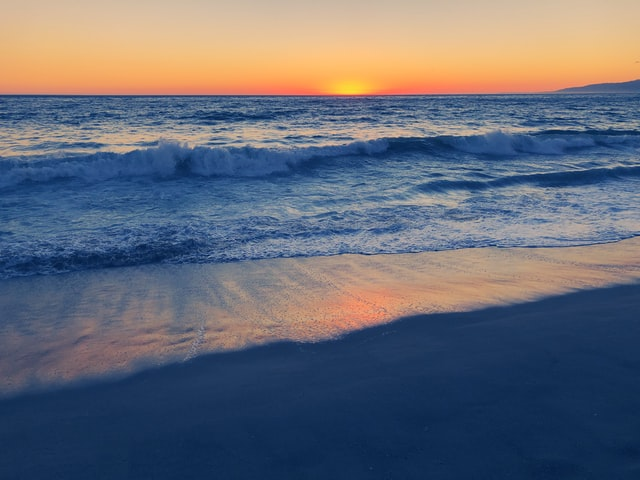

In [7]:
search("A sunset on the beach")

Query:


'London'

UnGcRvTyJOo.jpg


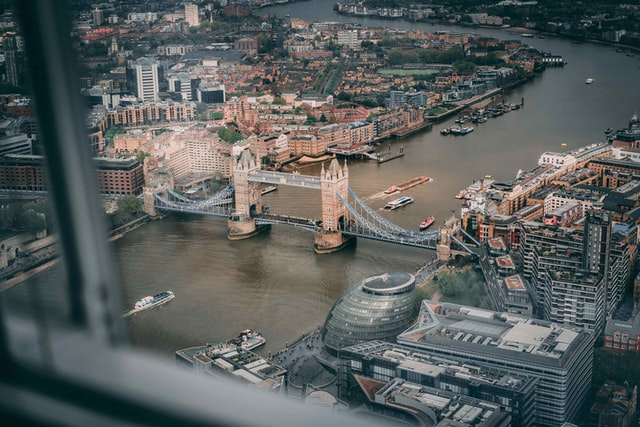

S3G8qX4Ft5s.jpg


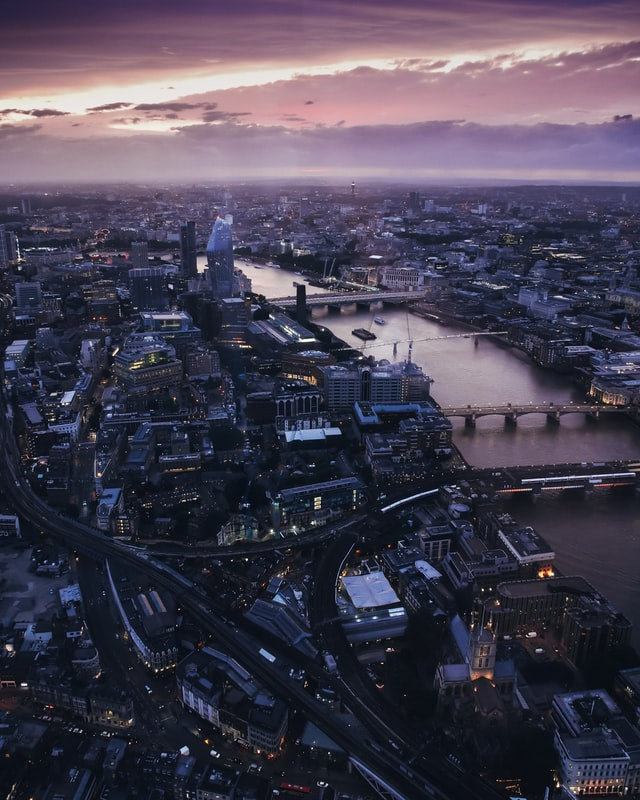

t05kfHeygbE.jpg


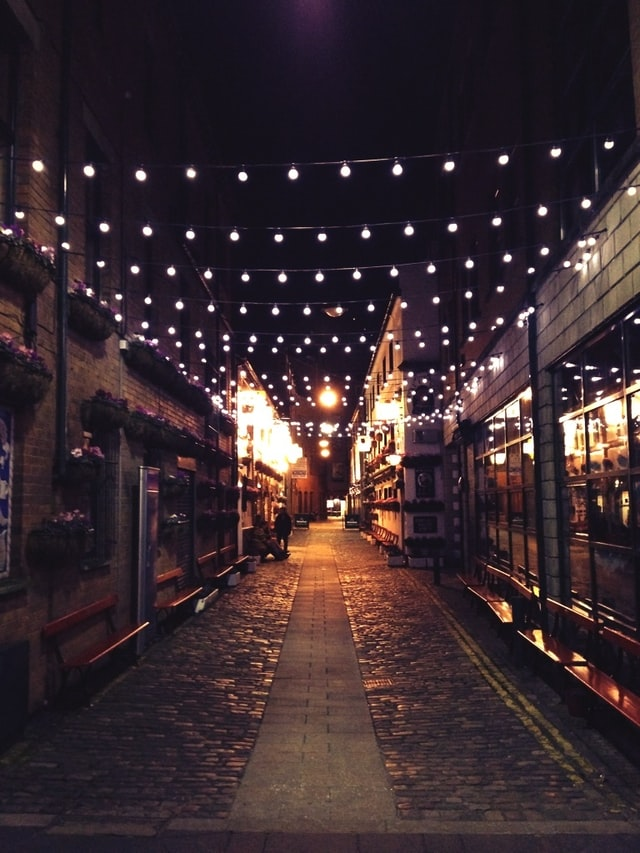

In [8]:
search("London")

Query:


'A dog in a park'

IVyZrLp41D0.jpg


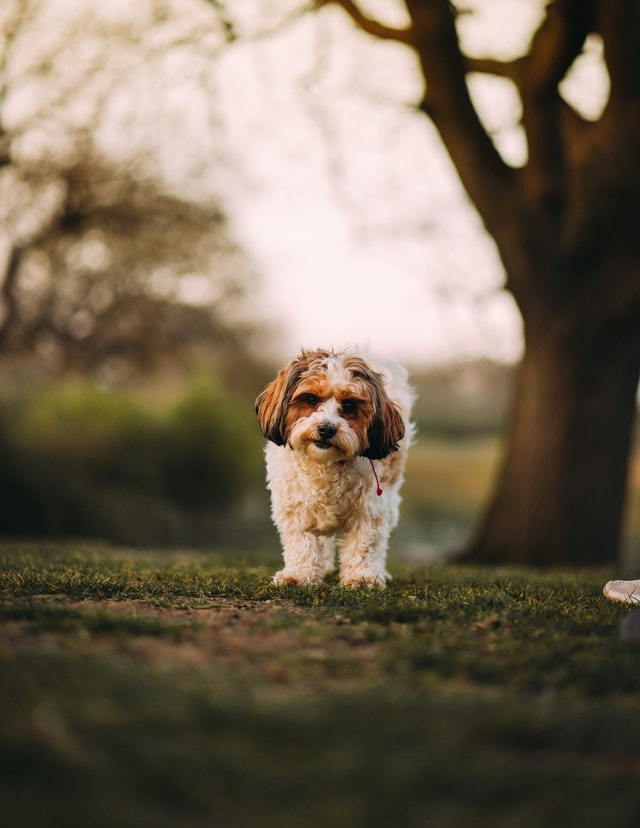

0O9A0F_d1qA.jpg


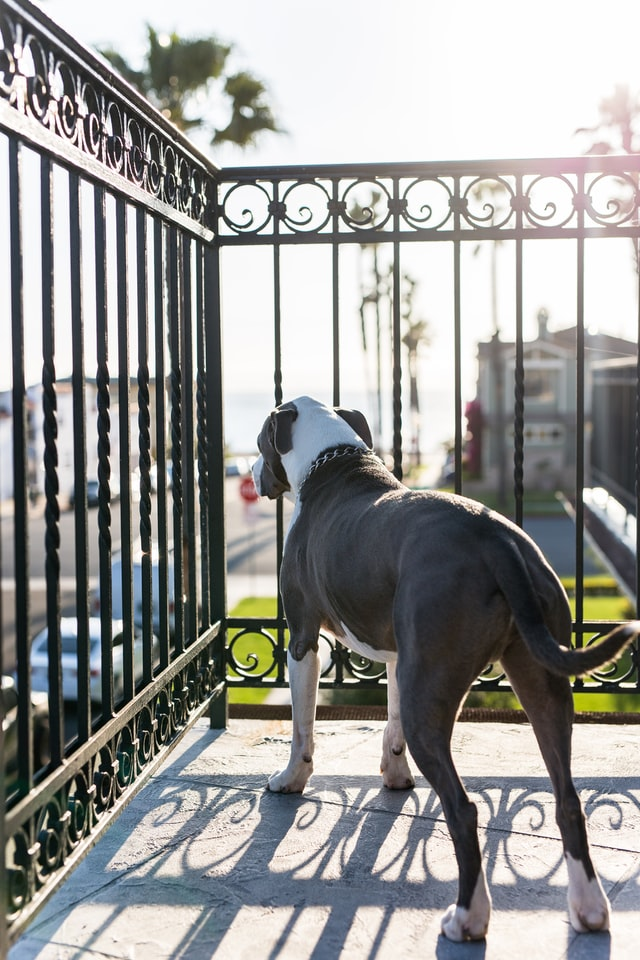

KVeogBZzl4M.jpg


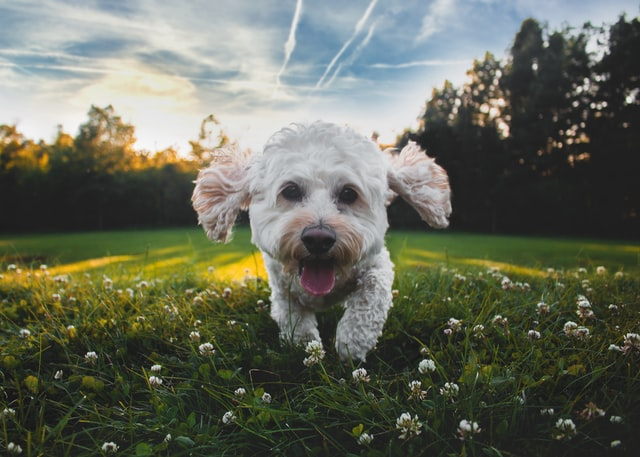

In [9]:
search("A dog in a park")

Query:


'A beach with palm trees'

7rrgPPljqYU.jpg


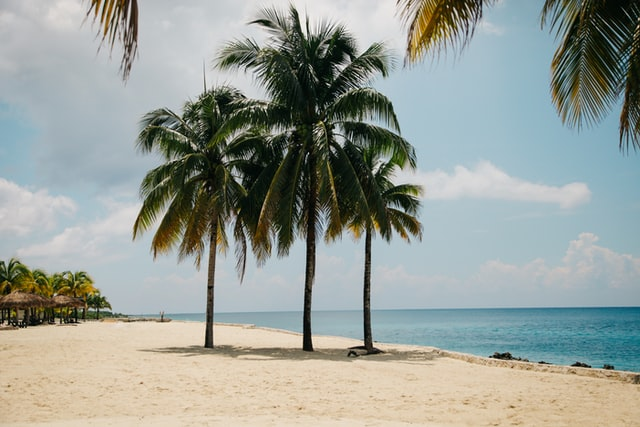

kmihWgpbDEg.jpg


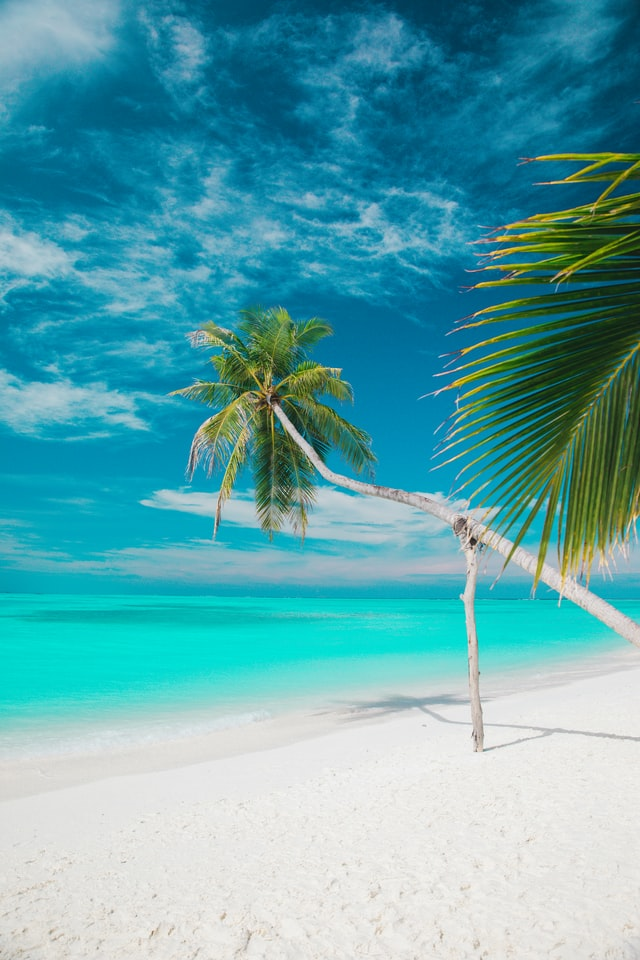

ZyfOq52b0cs.jpg


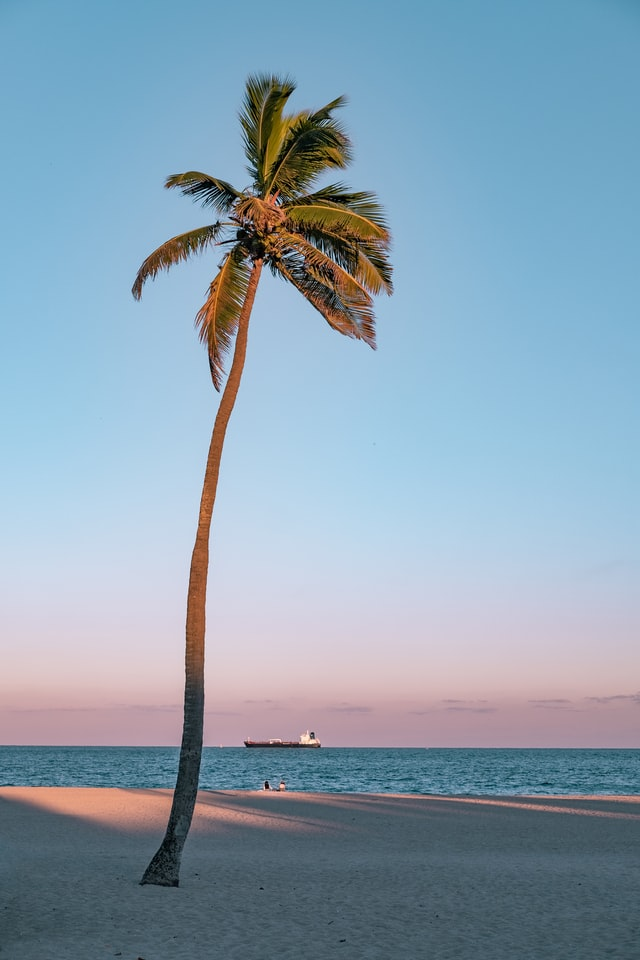

In [10]:
search("A beach with palm trees")

## Image-to-Image Search demo

You can use the method also for image-to-image search.

Query:


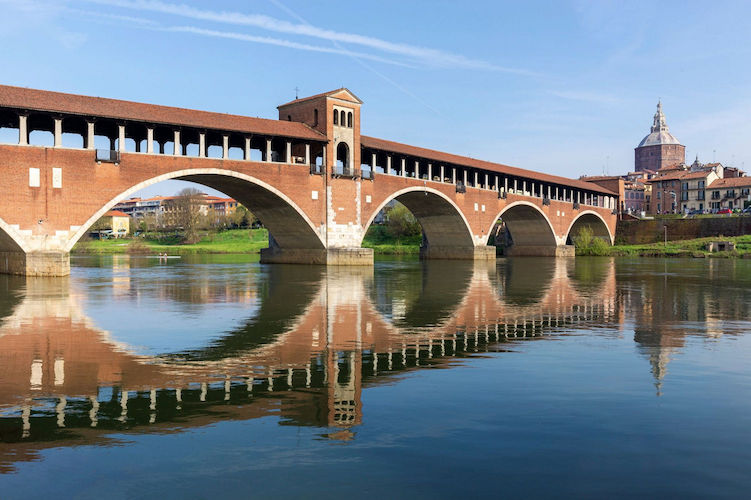

b9J0I29NI0w.jpg


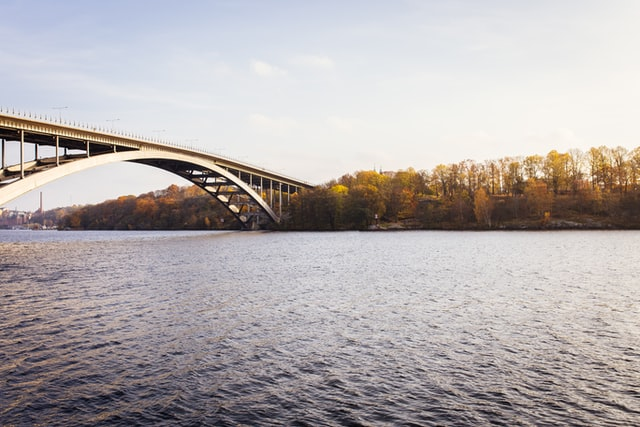

CLiIr15uGuU.jpg


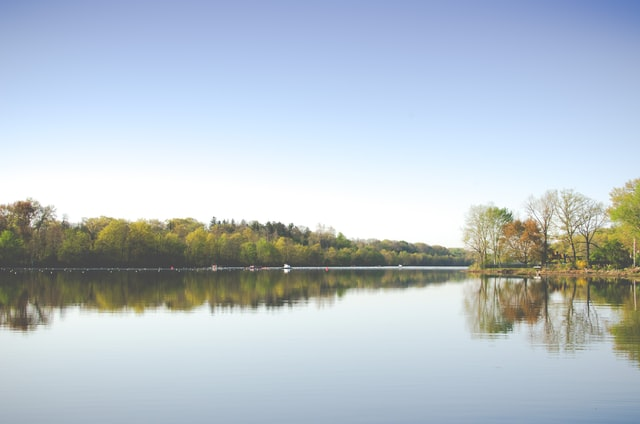

SOBE-JRyRww.jpg


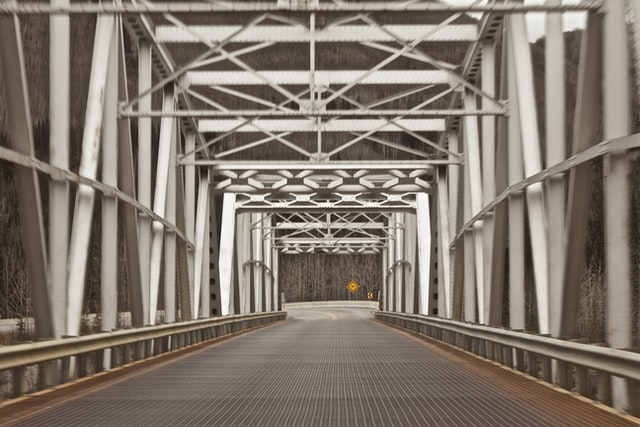

_4HhZOUEwmw.jpg


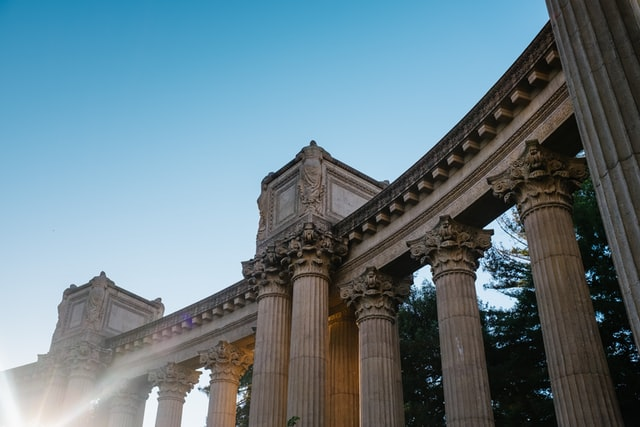

TkunxoS98q0.jpg


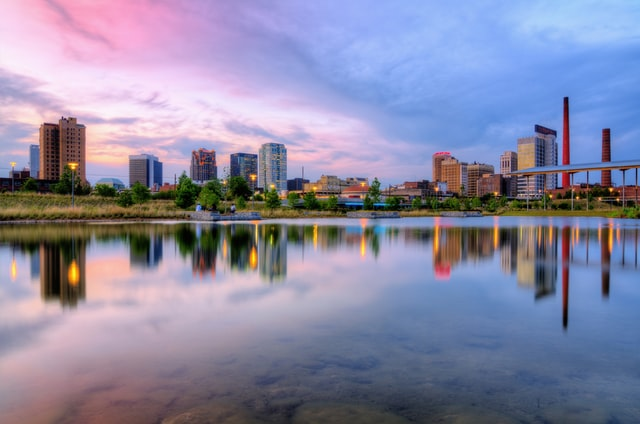

In [12]:
search(Image.open('./img/ponte-coperto.jpeg'), k=5)